# ECE 284 Project, Replicating research paper:
## *Understanding the ability of low-cost MOx sensors to quantify ambient VOCs*
#### By: Ashley M. Collier-Oxandale, Jacob Thorson, Hannah Halliday, Jana Milford, and Michael Hannigan

Article: https://amt.copernicus.org/articles/12/1441/2019/amt-12-1441-2019-discussion.html
Data: https://data.mendeley.com/datasets/hkn2tbcp67/1

The paper only implements linear regression, so I will first replicate the linear regression along with the plots generated by the paper, and then I will try using more advanced machine learning techniques, such as neural nets.

## Setup

In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from datetime import date
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize


class averageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
# the .mat file has the data stored in tables, so it is necessary to run the toPython.m script first

# labels appear as 'nan' when written to array, so making it array name
labels = ['Time', 'Temp', 'RH', 'Fig1v', 'Fig2v', 'ELT', 'e2vO3', 'e2vNO2', 'AH', 'Fig1r', 'Fig2r', 'Actd', 'Acet', 
          'Benz', 'C8', 'C9', 'Form', 'Meth', 'Tol', 'CH4', 'CO', 'O3', 'NO2', 'CO2', 'T_Plat', 'RH_Plat', 'H2S', 'TimeL']
full_labels = ['Time', 'Temperature', 'Relative Humidity', 'Figaro2600 (V)', 'Figaro2602 (V)', 'NDIR CO2', 'MOx O3', 'MOx NO2',
              'Absolute Humidity', 'Figaro2600 (nR)', 'Figaro2602 (nR)', 'Acetaldehyde', 'Acetone', 'Benzene', 'C8', 'C9',
              'Formaldehyde', 'Methanol', 'Toluene', 'Methane', 'Carbon Monoxide', 'Ozone', 'Nitrogen Dioxide', 
               'Carbon Dioxide', 'Temperature (native)', 'Relative Humidity (native)', 'Hydrogen Sulfide', 'Time (local)']

PrimaryUPod = np.genfromtxt('primary.csv', skip_header=1, delimiter=',')#, names=labels) 
SecondaryUPod = np.genfromtxt('secondary.csv', skip_header=1, delimiter=',')#, names=labels[:-1])

# including the name would make it a 1D array of tuples, so I'll just define a quick function to fetch by name 
def get_column(data, label, name):
    return data[:,label.index(name)]

In [3]:
# prepare the data for the regression
p_TimeL = get_column(PrimaryUPod, labels, 'TimeL')

# defining testing and training data
beg_testing = date.toordinal(date(2014,7,20))+366 # 366 needed to match with MATLAB times
end_testing = date.toordinal(date(2014,8,5))+366
ind1   = sum(p_TimeL <= beg_testing) # use sum to find last as 'True' == 1
ind2   = sum(p_TimeL <= end_testing)
ind1_1 = range(0, ind1)    # or use [:ind1]
ind1_2 = range(ind2, 4822) # or use [ind2:]
train  = list(ind1_1) + list(ind1_2) # for concatenation needs to be in list
test2  = range(ind1, ind2) 

# create the data bactches
x_data   = np.array([PrimaryUPod[:,9], PrimaryUPod[:,10] , PrimaryUPod[:,9] * PrimaryUPod[:,10], PrimaryUPod[:,1], PrimaryUPod[:,8], PrimaryUPod[:,0]]).T
x_train  = x_data[train,:]
x_test   = x_data[test2,:]

x_data2  = np.array([PrimaryUPod[:,9], PrimaryUPod[:,10] , PrimaryUPod[:,9] * PrimaryUPod[:,10], np.square(PrimaryUPod[:,4]), PrimaryUPod[:,1], PrimaryUPod[:,8], PrimaryUPod[:,1] * PrimaryUPod[:,10], PrimaryUPod[:,0]]).T
x_train2 = x_data2[train,:]
x_test2  = x_data2[test2,:]

# data for the aromatics and VOC which are a combination of others
aromatic = 6 * get_column(PrimaryUPod, labels, 'Benz') + 7 * get_column(PrimaryUPod, labels, 'Tol') + 8 * get_column(PrimaryUPod, labels, 'C8') + 9 * get_column(PrimaryUPod, labels, 'C9');
VOC = 6 * get_column(PrimaryUPod, labels, 'Benz') + 7 * get_column(PrimaryUPod, labels, 'Tol') + 8 * get_column(PrimaryUPod, labels, 'C8') + 9 * get_column(PrimaryUPod, labels, 'C9') + get_column(PrimaryUPod, labels, 'Meth') + 3 * get_column(PrimaryUPod, labels, 'Acet') + 2 * get_column(PrimaryUPod, labels, 'Actd') + get_column(PrimaryUPod, labels, 'Form');

# create lists for storing errors
stats_rc = []
stats_ec = []

### Linear Regression Implementation

In [4]:
def linear_fit(name, auto_gen_ticks = False, residuals_paper = False):
    # Get the data from the name
    if (name == 'Aro'):
        y_train = aromatic[train]
        y_test = aromatic[test2]
        full_name = "Summed Aromatics"
        reference = aromatic
    elif (name == 'VOC'):
        y_train = VOC[train]
        y_test = VOC[test2]
        full_name = "Summed PTR-MS VOCs"
        reference = VOC
    else:
        y_train = get_column(PrimaryUPod, labels, name)[train]
        y_test = get_column(PrimaryUPod, labels, name)[test2]
        full_name = full_labels[labels.index(name)]
        reference = get_column(PrimaryUPod, labels, name)
    
    plt_ur = (int(max(y_test) / 10) + 1) * 10
    if  (name == 'Benz'):
        plt_ur = 21;
    elif (name == 'CH4'):
        plt_ur = 10;
    elif (name == 'Aro'):
        plt_ur = 250;
    elif (name == 'VOC'):
        plt_ur = 150;
    
    # General Linear Regression Models

    mdl = LinearRegression().fit(x_train, y_train)
    fitted = mdl.predict(x_train)
    predicted = mdl.predict(x_test)
    r0 = mdl.score(x_train, y_train)
    e0 = mean_squared_error(fitted, y_train, squared=False) # false for getting the RMSE
    r1 = mdl.score(x_test, y_test)
    e1 = mean_squared_error(predicted, y_test, squared=False)

    mdl2 = LinearRegression().fit(x_train2, y_train)
    fitted2 = mdl2.predict(x_train2)
    predicted2 = mdl2.predict(x_test2)
    r2 = mdl2.score(x_train2, y_train)
    e2 = mean_squared_error(fitted2, y_train, squared=False)
    r3 = mdl2.score(x_test2, y_test)
    e3 = mean_squared_error(predicted2, y_test, squared=False)


    # General Plots

    plt.plot(p_TimeL, reference, 'k', linewidth=1);
    plt.plot(p_TimeL[train], fitted, '--b', linewidth=1);
    plt.plot(p_TimeL[test2], predicted, '--r', linewidth=1);
    plt.plot(p_TimeL[train], fitted2, '--y', linewidth=1);
    plt.plot(p_TimeL[test2], predicted2, '--g', linewidth=1);
    plt.title(full_name);
    plt.xlabel('Local Time');
    plt.ylabel(full_name + ', ppb');
    plt.legend(['Reference (PTR-MS)', f'Training: $R^2$ = {round(r0,2)} , RMSE = {round(e0,2)}', 
               f'Testing: $R^2$ = {round(r1,2)} , RMSE = {round(e1,2)}',f'Training: $R^2$ = {round(r2,2)} , RMSE = {round(e2,2)}',
               f'Testing: $R^2$ = {round(r3,2)} , RMSE = {round(e3,2)}']);

    if auto_gen_ticks: # use the autogen spacing from python, else use the ones from paper
        locs, t_labels = plt.xticks()
        i = 0; date_arr = []
        for dd in locs.astype(int):
            day = date.fromordinal(dd-366)
            date_arr.append(str(day.month) + '/' + str(day.day)) # f'{day.month}/{day.day}'
            i+=1
    else:
        i = 0; locs = []
        date_arr = ['07/18', '07/20', '07/22', '07/24', '07/26', '07/28', '07/30', '08/01', '08/03', '08/05', '08/07', '08/09']
        for dd in date_arr:
            aa = dd.split('/')
            locs.append(date.toordinal(date(2014,int(aa[0]),int(aa[1])))+366)
            i+=1
    plt.xticks(locs, date_arr, fontsize = 8); # change ord number to readable date for the x-axis
    plt.axvspan(p_TimeL[0], beg_testing, color='yellow', alpha=0.15) # highlight the training data
    plt.axvspan(end_testing, p_TimeL[-1], color='yellow', alpha=0.15)
    plt.show()


    plt.scatter(predicted, y_test, c='b', marker='+')
    plt.scatter(predicted2, y_test, c='r', marker='x')
    plt.plot(range(0,plt_ur),range(0,plt_ur), '--k')
    plt.axis('square')
    plt.xlabel('Sensor data (testing)');
    plt.ylabel(full_name + ', ppb');
    plt.legend(["1:1 line", 'Mdl1', "Mdl2"])
    plt.show()


    if residuals_paper: # Residuals shown as in the paper, else split in 4 subplots
        raw_res = y_test - predicted
        raw_res2 = y_test - predicted2

        plt.figure().set_figwidth(2) # make plot thin
        plt.xlim(-0.5, 1.5)

        plt.scatter(np.zeros([len(raw_res)]), raw_res, c='k', marker='+')
        plt.scatter(np.ones([len(raw_res)]), raw_res2, c='k', marker='+')
        plt.xlabel('Residuals')
        plt.ylabel('Testing data, ppb')
        plt.xticks([0,1],['Mdl1', 'Mdl2'])

        # draw mean and 5th/95th percentile
        mean = raw_res.mean()
        mean2 = raw_res2.mean()
        p_05 = np.percentile(raw_res, 5)
        p_95 = np.percentile(raw_res, 95)
        p_052 = np.percentile(raw_res2, 5)
        p_952 = np.percentile(raw_res2, 95)
        #plt.errorbar(0, mean, std, ecolor='r', elinewidth=3, barsabove=True)
        plt.plot([-0.2, 0.2], [p_05, p_05], 'r')
        plt.plot([-0.2, 0.2], [mean, mean], 'r', linewidth=1)
        plt.plot([-0.2, 0.2], [p_95, p_95], 'r')
        plt.plot([0.8, 1.2], [p_052, p_052], 'r')
        plt.plot([0.8, 1.2], [mean2, mean2], 'r', linewidth=1)
        plt.plot([0.8, 1.2], [p_952, p_952], 'r')
        plt.show() # was fixed to be 5th and 95th percentile rather than std
    else:
        raw_res = y_train - fitted
        std_res = raw_res / np.std(raw_res)
        raw_res2 = y_train - fitted2
        std_res2 = raw_res2 / np.std(raw_res2)

        plt.subplot(2,2,1)
        plt.scatter(y_train, std_res, c = 'b', marker = '*')
        plt.scatter(y_train, std_res2, c = 'r', marker = '*')
        plt.title('Residuals vs. Concentration')
        #lsline
        m, b = np.polyfit(y_train, std_res, deg=1)
        m2, b2 = np.polyfit(y_train, std_res2, deg=1)
        plt.axline(xy1=(0, b), slope=m)
        plt.axline(xy1=(0, b2), slope=m2)

        plt.subplot(2,2,2)
        plt.scatter(get_column(PrimaryUPod, labels, 'Temp')[train], std_res, c = 'b', marker = '*')
        plt.scatter(get_column(PrimaryUPod, labels, 'Temp')[train], std_res2, c = 'r', marker = '*')
        #plt.axis('square')
        plt.title('Residuals vs. Temperature')
        #lsline
        m, b = np.polyfit(get_column(PrimaryUPod, labels, 'Temp')[train], std_res, deg=1)
        m2, b2 = np.polyfit(get_column(PrimaryUPod, labels, 'Temp')[train], std_res2, deg=1)
        plt.axline(xy1=(0, b), slope=m)
        plt.axline(xy1=(0, b2), slope=m2)

        plt.subplot(2,2,3)
        plt.scatter(get_column(PrimaryUPod, labels, 'AH')[train], std_res, c = 'b', marker = '*')
        plt.scatter(get_column(PrimaryUPod, labels, 'AH')[train], std_res2, c = 'r', marker = '*')
        #plt.axis('square')
        plt.title('Residuals vs. Absolute Humidity')
        #lsline
        m, b = np.polyfit(get_column(PrimaryUPod, labels, 'AH')[train], std_res, deg=1)
        m2, b2 = np.polyfit(get_column(PrimaryUPod, labels, 'AH')[train], std_res2, deg=1)
        plt.axline(xy1=(0, b), slope=m)
        plt.axline(xy1=(0, b2), slope=m2)
        plt.xlim(0.01, 0.02)

        plt.subplot(2,2,4)
        plt.scatter(get_column(PrimaryUPod, labels, 'Time')[train], std_res, c = 'b', marker = '*')
        plt.scatter(get_column(PrimaryUPod, labels, 'Time')[train], std_res2, c = 'r', marker = '*')
        #plt.axis('square')
        plt.title('Residuals vs. Time')
        #lsline
        m, b = np.polyfit(get_column(PrimaryUPod, labels, 'Time')[train], std_res, deg=1)
        m2, b2 = np.polyfit(get_column(PrimaryUPod, labels, 'Time')[train], std_res2, deg=1)
        plt.axline(xy1=(0, b), slope=m)
        plt.axline(xy1=(0, b2), slope=m2)
        plt.xlim(get_column(PrimaryUPod, labels, 'Time')[train][0], get_column(PrimaryUPod, labels, 'Time')[train][-1])

        plt.tight_layout()
        plt.show()
    return mdl, mdl2

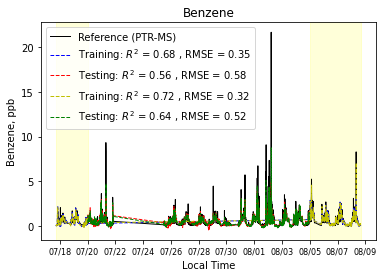

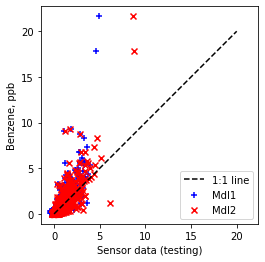

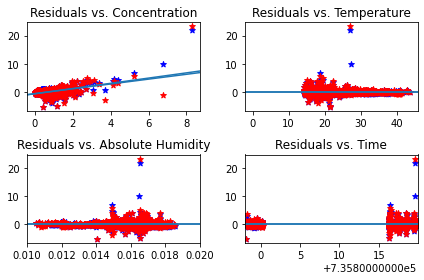

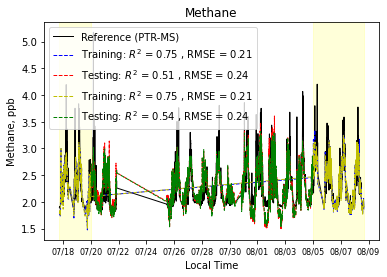

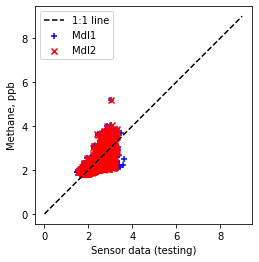

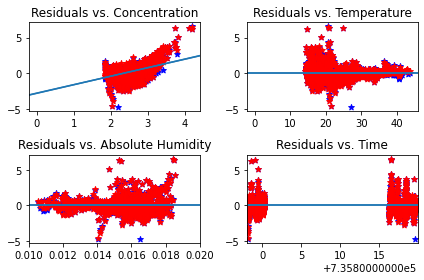

(LinearRegression(), LinearRegression())

In [5]:
mdl_b, mdl_b1 = linear_fit("Benz") # Benzene Fit
linear_fit("CH4")  # Methane Fit

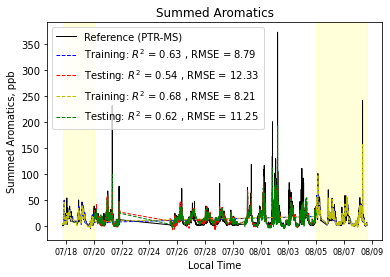

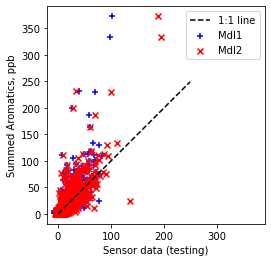

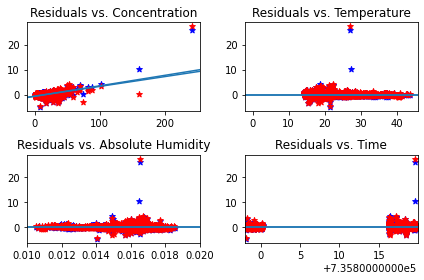

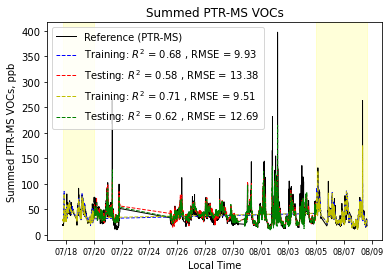

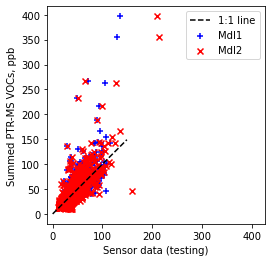

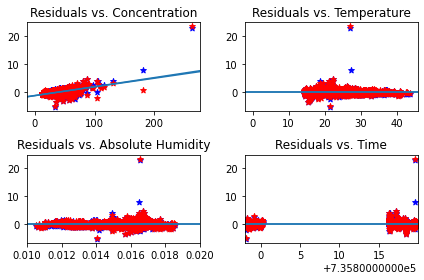

(LinearRegression(), LinearRegression())

In [6]:
linear_fit("Aro")  # Aromatics Fit
linear_fit("VOC")  # VOC's Fit

## Maybe also implement the SecodnaryUPod, and VOCSensorDataExcluded

## Iterative Fitting from paper

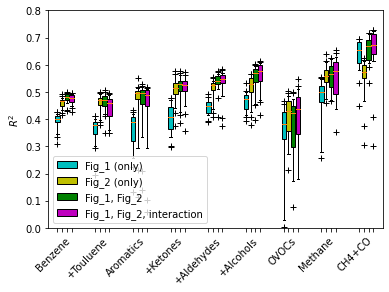

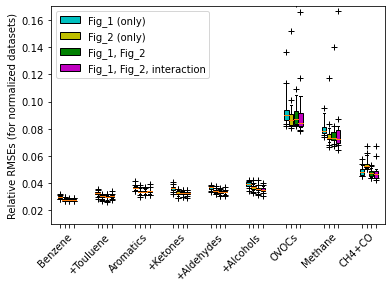

In [7]:
# Create the expected Sums
Sums_exp = np.zeros([len(PrimaryUPod), 9])
Sums_exp[:,0] = 6 * get_column(PrimaryUPod, labels, 'Benz')
Sums_exp[:,1] = Sums_exp[:,0] + 7 * get_column(PrimaryUPod, labels, 'Tol')
Sums_exp[:,2] = Sums_exp[:,1] + 8 * get_column(PrimaryUPod, labels, 'C8') + 9 * get_column(PrimaryUPod, labels, 'C9')
Sums_exp[:,3] = Sums_exp[:,2] + 3 * get_column(PrimaryUPod, labels, 'Acet')
Sums_exp[:,4] = Sums_exp[:,3] + 2 * get_column(PrimaryUPod, labels, 'Actd') + get_column(PrimaryUPod, labels, 'Form')
Sums_exp[:,5] = Sums_exp[:,4] + get_column(PrimaryUPod, labels, 'Meth') + 2 * get_column(PrimaryUPod, labels, 'Actd') + get_column(PrimaryUPod, labels, 'Form')
Sums_exp[:,6] = get_column(PrimaryUPod, labels, 'Meth') + 3 * get_column(PrimaryUPod, labels, 'Acet') 
Sums_exp[:,7] = get_column(PrimaryUPod, labels, 'CH4')
Sums_exp[:,8] = Sums_exp[:,7] + 1/1000 * get_column(PrimaryUPod, labels, 'CO')
Sums = (Sums_exp - Sums_exp.min(0)) / (Sums_exp.max(0) - Sums_exp.min(0))

dataset = PrimaryUPod / np.linalg.norm(PrimaryUPod,axis=0) # most likely not the specific normalization
dataset1= dataset[:, [9, 1, 8, 0]]; # for mdl1
dataset2= dataset[:, [10, 1, 8, 0]]; # for mdl2
dataset3= dataset[:, [9, 10, 1, 8, 0]]; # for mdl3
dataset4= np.append(dataset[:, [9, 10, 1, 8, 0]], (dataset[:, 9] * dataset[:, 8]).reshape(-1,1), 1) # for mdl4
ind_all = range(0, len(PrimaryUPod));

stats_r = []; stats_e = [];
for range2 in range(0,9):
    stats_rt = []; stats_et = [];
    for range1 in range(0,25):
        ind = np.random.permutation(len(PrimaryUPod)-40)[0:18];
        train = [];
        for ind1 in ind:
            train = train + (list(range(ind1, ind1+40)))
        #train0 = dataset[train]
        
        test_ind = list(set(ind_all) - set(train))  
        
        mdl1 = LinearRegression().fit(dataset1[train], Sums[train, range2])
        mdl2 = LinearRegression().fit(dataset2[train], Sums[train, range2])
        mdl3 = LinearRegression().fit(dataset3[train], Sums[train, range2])
        mdl4 = LinearRegression().fit(dataset4[train], Sums[train, range2])
        
        r = []; e = [];
        r.append(mdl1.score(dataset1[test_ind], Sums[test_ind, range2])); 
        fit1 = mdl1.predict(dataset1[test_ind]);
        e.append(mean_squared_error(fit1, Sums[test_ind, range2], squared=False));
        
        r.append(mdl2.score(dataset2[test_ind], Sums[test_ind, range2])); 
        fit2 = mdl2.predict(dataset2[test_ind]);
        e.append(mean_squared_error(fit2, Sums[test_ind, range2], squared=False));
        
        r.append(mdl3.score(dataset3[test_ind], Sums[test_ind, range2])); 
        fit3 = mdl3.predict(dataset3[test_ind]);
        e.append(mean_squared_error(fit3, Sums[test_ind, range2], squared=False));
        
        r.append(mdl4.score(dataset4[test_ind], Sums[test_ind, range2])); 
        fit4 = mdl4.predict(dataset4[test_ind]);
        e.append(mean_squared_error(fit4, Sums[test_ind, range2], squared=False));
        stats_rt.append(r); stats_et.append(e);
    stats_r.append(stats_rt); stats_e.append(stats_et);

# and now the plots
positions = [1,1.25,1.5,1.75,3,3.25,3.5,3.75,5,5.25,5.5,5.75,7,7.25,7.5,7.75,9,9.25,9.5,9.75,11,11.25,11.5,11.75,13,13.25,13.5,13.75,15,15.25,15.5,15.75,17,17.25,17.5,17.75]
pos_labels = ["","","","Benzene","","","","+Touluene","","","","Aromatics","","","","+Ketones","","","","+Aldehydes","","","","+Alcohols","","","","OVOCs","","","","Methane","","","","CH4+CO"]
colors = ['c','y','g','m','c','y','g','m','c','y','g','m','c','y','g','m','c','y','g','m','c','y','g','m','c','y','g','m','c','y','g','m','c','y','g','m'];
stats_rd = np.array(stats_r)
stats_rd = np.transpose(stats_rd, (1,0,2))
stats_rd = stats_rd.reshape(-1,stats_rd.shape[1] * stats_rd.shape[2])
stats_ed = np.array(stats_e)
stats_ed = np.transpose(stats_ed, (1,0,2))
stats_ed = stats_ed.reshape(-1,stats_ed.shape[1] * stats_ed.shape[2])

fig, ax = plt.subplots()
ax.set_ylabel('$R^2$')
bplot = ax.boxplot(stats_rd, positions=positions, widths=0.24, whis=(5,95), sym="+", patch_artist=True);

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color);
ax.set_xticklabels(pos_labels)
plt.xticks(rotation=45, ha="right")
#plt.legend(["Fig_1 (only)", "Fig_2 (only)", "Fig_1, Fig_2", "Fig_1, Fig_2, interaction"])
ax.legend([bplot['boxes'][0],bplot['boxes'][1],bplot['boxes'][2],bplot['boxes'][3]], ["Fig_1 (only)", "Fig_2 (only)", "Fig_1, Fig_2", "Fig_1, Fig_2, interaction"], loc='lower left')
plt.ylim(0,0.8)
plt.show()

fig, ax = plt.subplots()
ax.set_ylabel('Relative RMSEs (for normalized datasets)')
bplot = ax.boxplot(stats_ed, positions=positions, widths=0.24, whis=(5,95), sym="+", patch_artist=True);

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color);
ax.set_xticklabels(pos_labels)
plt.xticks(rotation=45, ha="right")
#plt.legend(["Fig_1 (only)", "Fig_2 (only)", "Fig_1, Fig_2", "Fig_1, Fig_2, interaction"])
ax.legend([bplot['boxes'][0],bplot['boxes'][1],bplot['boxes'][2],bplot['boxes'][3]], ["Fig_1 (only)", "Fig_2 (only)", "Fig_1, Fig_2", "Fig_1, Fig_2, interaction"], loc='upper left')
plt.ylim(0.01,0.17)
plt.show()

## My Models Improved

### Train a model for each individually

In [34]:
# need to rerun because the training was changed due to random iteration

# prepare the data for the regression
p_TimeL = get_column(PrimaryUPod, labels, 'TimeL')

# defining testing and training data
beg_testing = date.toordinal(date(2014,7,20))+366 # 366 needed to match with MATLAB times
end_testing = date.toordinal(date(2014,8,5))+366
ind1   = sum(p_TimeL <= beg_testing) # use sum to find last as 'True' == 1
ind2   = sum(p_TimeL <= end_testing)
ind1_1 = range(0, ind1)    # or use [:ind1]
ind1_2 = range(ind2, 4822) # or use [ind2:]
train  = list(ind1_1) + list(ind1_2) # for concatenation needs to be in list
test2  = range(ind1, ind2) 

# create the data bactches
x_data   = np.array([PrimaryUPod[:,9], PrimaryUPod[:,10] , PrimaryUPod[:,9] * PrimaryUPod[:,10], PrimaryUPod[:,1], PrimaryUPod[:,8], PrimaryUPod[:,0]]).T
x_train  = x_data[train,:]
x_test   = x_data[test2,:]

x_data2  = np.array([PrimaryUPod[:,9], PrimaryUPod[:,10] , PrimaryUPod[:,9] * PrimaryUPod[:,10], np.square(PrimaryUPod[:,4]), PrimaryUPod[:,1], PrimaryUPod[:,8], PrimaryUPod[:,1] * PrimaryUPod[:,10], PrimaryUPod[:,0]]).T
x_train2 = x_data2[train,:]
x_test2  = x_data2[test2,:]

# data for the aromatics and VOC which are a combination of others
aromatic = 6 * get_column(PrimaryUPod, labels, 'Benz') + 7 * get_column(PrimaryUPod, labels, 'Tol') + 8 * get_column(PrimaryUPod, labels, 'C8') + 9 * get_column(PrimaryUPod, labels, 'C9');
VOC = 6 * get_column(PrimaryUPod, labels, 'Benz') + 7 * get_column(PrimaryUPod, labels, 'Tol') + 8 * get_column(PrimaryUPod, labels, 'C8') + 9 * get_column(PrimaryUPod, labels, 'C9') + get_column(PrimaryUPod, labels, 'Meth') + 3 * get_column(PrimaryUPod, labels, 'Acet') + 2 * get_column(PrimaryUPod, labels, 'Actd') + get_column(PrimaryUPod, labels, 'Form');

# create lists for storing errors
stats_rc = []
stats_ec = []

In [35]:
class NeuralNet(nn.Module):
    # Neural network with one hidden layer
    def __init__(self, linear_dim=[64,1], activation=nn.ReLU()):
        super(NeuralNet, self).__init__()   
        self.linlayers = nn.ModuleList([nn.Linear(linear_dim[i], linear_dim[i+1]) for i in range(len(linear_dim)-1)])
        self.act = activation

    def forward(self, x):        
        for idx in range(len(self.linlayers)-1):
            x = self.act(self.linlayers[idx](x))
        y = self.linlayers[-1](x)
        return y
    
def score(y_true, y_pred):
    u = (y_true - y_pred).square().sum()
    v = ((y_true - y_true.mean()).square()).sum()
    return 1 - u/v # equation doesnt seem to work
    

def train_NN(model, data, target, optimizer, criterion, batch_size=64, n_epoch=30):

    # setup random seed
    #torch.manual_seed(1337)
    #torch.cuda.manual_seed(1337)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

    # setup optimizer
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.5)
    #optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay= 0.9)
    #criterion = nn.MSELoss()

    # training and evaluation
    losses_train = []
    errs_train = []
    losses_test = []
    errs_test = []
    idx_used = torch.tensor([1])
    for ep in range(n_epoch):
        #model.train()
        optimizer.zero_grad()
        
        # forward the data to the model and get the output
        batch_idx = torch.randint(data.shape[0], (batch_size,))
        output = model(data)
        
        loss = criterion(output, target)
        
        # backward (PyTorch computes backpropagation for you)
        loss.backward()
        optimizer.step()
        
        losses_train.append(loss.item())
        #errs_train.append(acc_train)
        #idx_used = torch.cat((idx_used, batch_idx)).unique()
        #print(idx_used.shape[0]/data.shape[0])
        #print(idx_used)

        if int(ep % (n_epoch/10)) == 0:
            #model.test()
            # evaluate current model and get the loss
            #loss_test, acc_test = test(test_loader, model, criterion, device)
            #err = criterion(output, target[batch_idx])
            #losses_test.append(loss)
            #errs_test.append(err)
            t_lr = optimizer.param_groups[0]['lr']
            print(f'[{ep}]\tloss_train: {loss:.4f}\tlr: {t_lr}')

    # plot the training/testing loss and accuracy
    #fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    plt.semilogy(np.arange(n_epoch), losses_train, color='b', label='train_loss')
    #ax[0].plot(np.linspace(0, n_epoch, n_epoch//eval_epoch), losses_test, color='r', label='test_loss')
#    ax[0].legend()

 #   ax[1].plot(np.arange(n_epoch), errs_train, color='b', label='train_acc')
    #ax[1].plot(np.linspace(0, n_epoch, n_epoch//eval_epoch), errs_test, color='r', label='test_acc')
  #  ax[1].legend()
    return losses_train

[0]	loss_train: 47296048.2754	lr: 0.0


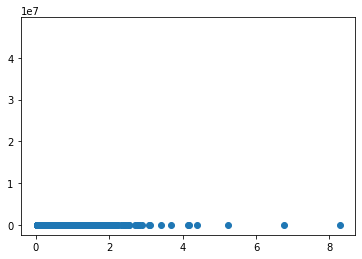

0.6752731869473103

In [45]:
#x_data   = np.array([PrimaryUPod[:,9], PrimaryUPod[:,10] , PrimaryUPod[:,9] * PrimaryUPod[:,10], PrimaryUPod[:,1], PrimaryUPod[:,8], PrimaryUPod[:,0]]).T
x_train  = x_data[train,:]
xx_train = x_train
xx_train[:,-1] = xx_train[:,-1] - xx_train[:,-1].min()#/ np.linalg.norm(xx_train[:,-1],axis=0)
xx_train = torch.from_numpy(xx_train)# .float().to(device)
benz_train = get_column(PrimaryUPod, labels, 'Benz')[train]
benz_test = get_column(PrimaryUPod, labels, 'Benz')[test2]
#benz_train = torch.from_numpy(benz_train[:4]).to(device).float()
yy_train = torch.from_numpy(benz_train)#.float()#.to(device)


model_linear = NeuralNet([xx_train.shape[1],1]).double()
# copy the linear regression to verify that it works
with torch.no_grad():
    model_linear.linlayers[0].weight[0] = torch.from_numpy(mdl_b.coef_)
    model_linear.linlayers[0].bias[0] = torch.from_numpy(np.array(mdl_b.intercept_))
criterion = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0000, weight_decay=0.1, momentum=0.1)
optimizer = torch.optim.Adagrad(model_linear.parameters(), lr=0.00)

losses_train = train_NN(model_linear, xx_train, yy_train.reshape(-1,1), optimizer, criterion, n_epoch= 1)
#print(min(losses_train))
y_pred, y_true = model_linear(xx_train) , yy_train
plt.scatter(y_true.detach().numpy(), y_pred.detach().numpy())
plt.yscale('linear')
#plt.ylim(0,10)
plt.show()
mdl_score = LinearRegression().fit(y_pred.detach().numpy(), y_true.detach().numpy())
mdl_score.score(y_pred.detach().numpy(), y_true.detach().numpy())

In [46]:
# plot above is wrong, for some reason it doesnt duplicate properly
mdl_b.coef_ , model_linear.linlayers[0].weight[0] , mdl_b.intercept_ , model_linear.linlayers[0].bias[0]

(array([-8.55752887e+00, -1.08593536e+01,  1.06421778e+01, -4.11945902e-02,
         1.26142801e+01, -9.34660368e-03]),
 tensor([-8.5575e+00, -1.0859e+01,  1.0642e+01, -4.1195e-02,  1.2614e+01,
         -9.3466e-03], grad_fn=<SelectBackward0>),
 6887.3387794769,
 tensor(6887.3388, grad_fn=<SelectBackward0>))

In [29]:
y_pred.detach().numpy().T.squeeze(), y_true.detach().numpy()

(array([6877.36585048, 6877.37830807, 6877.37247044, ..., 6877.33891636,
        6877.3244033 , 6877.24349081]),
 array([0.05   , 0.03975, 0.082  , ..., 0.08175, 0.0924 , 0.07675]))

[0]	loss_train: 0.8930	lr: 0.01
[10]	loss_train: 0.3886	lr: 0.01
[20]	loss_train: 0.4034	lr: 0.01
[30]	loss_train: 0.4147	lr: 0.01
[40]	loss_train: 0.4244	lr: 0.01
[50]	loss_train: 0.4194	lr: 0.01
[60]	loss_train: 0.4181	lr: 0.01
[70]	loss_train: 0.4195	lr: 0.01
[80]	loss_train: 0.4185	lr: 0.01
[90]	loss_train: 0.4190	lr: 0.01


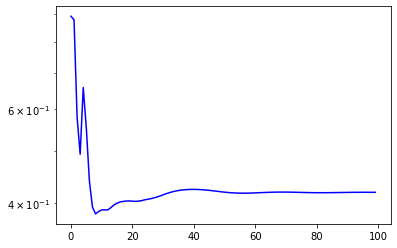

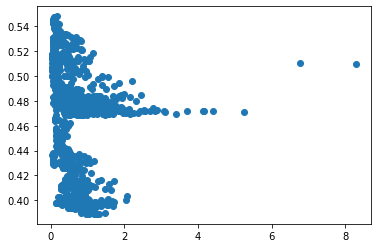

-124717107.07084414

In [37]:
#x_data   = np.array([PrimaryUPod[:,9], PrimaryUPod[:,10] , PrimaryUPod[:,9] * PrimaryUPod[:,10], PrimaryUPod[:,1], PrimaryUPod[:,8], PrimaryUPod[:,0]]).T
x_train  = x_data[train,:]
xx_train = x_train
xx_train[:,-1] = xx_train[:,-1] - xx_train[:,-1].min()#/ np.linalg.norm(xx_train[:,-1],axis=0)
xx_train = torch.from_numpy(xx_train)# .float().to(device)
benz_train = get_column(PrimaryUPod, labels, 'Benz')[train]
benz_test = get_column(PrimaryUPod, labels, 'Benz')[test2]
linear_dim = [xx_train.shape[1], 16, 16, 1]
#benz_train = torch.from_numpy(benz_train[:4]).to(device).float()
yy_train = torch.from_numpy(benz_train)#.float()#.to(device)

model = NeuralNet(linear_dim).double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1, momentum=0.9)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model normally
losses_train = train_NN(model, xx_train, yy_train.reshape(-1,1), optimizer, criterion, n_epoch= 100)
min(losses_train) # result is trash because of time T_T

# show results more concretely
y_pred, y_true = model(xx_train) , yy_train
plt.figure()
plt.scatter(y_true.detach().numpy(), y_pred.detach().numpy())
plt.show()
mdl_score.score(y_pred.detach().numpy(), y_true.detach().numpy())

(1387, 5)
[0]	loss_train: 1.1778	lr: 0.01
[10]	loss_train: 0.4315	lr: 0.01
[20]	loss_train: 0.4262	lr: 0.01
[30]	loss_train: 0.4210	lr: 0.01
[40]	loss_train: 0.4161	lr: 0.01
[50]	loss_train: 0.4113	lr: 0.01
[60]	loss_train: 0.4067	lr: 0.01
[70]	loss_train: 0.4022	lr: 0.01
[80]	loss_train: 0.3979	lr: 0.01
[90]	loss_train: 0.3938	lr: 0.01


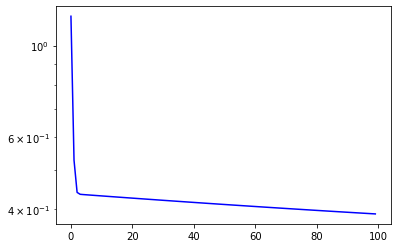

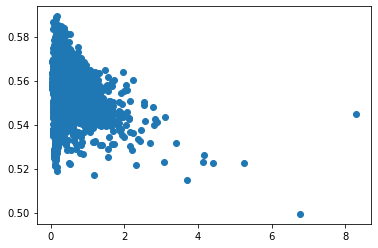

-124714014.84664214

In [13]:
#x_data   = np.array([PrimaryUPod[:,9], PrimaryUPod[:,10] , PrimaryUPod[:,9] * PrimaryUPod[:,10], PrimaryUPod[:,1], PrimaryUPod[:,8], PrimaryUPod[:,0]]).T
x_train  = x_data[train,:]
xx_train = x_train[:,:-1]
print(xx_train.shape)
#xx_train[:,-1] = xx_train[:,-1] - xx_train[:,-1].min()#/ np.linalg.norm(xx_train[:,-1],axis=0)
xx_train = torch.from_numpy(xx_train)# .float().to(device)
benz_train = get_column(PrimaryUPod, labels, 'Benz')[train]
benz_test = get_column(PrimaryUPod, labels, 'Benz')[test2]
linear_dim = [xx_train.shape[1], 16, 16, 1]
#benz_train = torch.from_numpy(benz_train[:4]).to(device).float()
yy_train = torch.from_numpy(benz_train)#.float()#.to(device)

model = NeuralNet(linear_dim).double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.)#, momentum=0.9)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model normally
losses_train = train_NN(model, xx_train, yy_train.reshape(-1,1), optimizer, criterion, n_epoch= 100)
min(losses_train) # result is trash because of time T_T

# show results more concretely
y_pred, y_true = model(xx_train) , yy_train
plt.figure()
plt.scatter(y_true.detach().numpy(), y_pred.detach().numpy())
plt.show()
mdl_score.score(y_pred.detach().numpy(), y_true.detach().numpy())

(1387, 8)
[0]	loss_train: 44180418.0341	lr: 0.001
[10]	loss_train: 344987738990924976760102026088672471934269104735049447055022047923285107422899043267546442586306702267394708250050402793573957594615943924533369231656477049014725574930172737034131603456.0000	lr: 0.001
[20]	loss_train: 331447300397885188003582474469582076369206124637496649861656224350902943675591597770726405071427811530086399046988347161398988848896073391517891236548449117661870107309052347497232465920.0000	lr: 0.001
[30]	loss_train: 318438311061065935197586377797637691012892715051387009207515044386755325015020319620133046850694241187314551057800639175473184346206423934091890657931418174775582541813411822578689900544.0000	lr: 0.001
[40]	loss_train: 305939912105771405163441547186983291689961635820955212745991298757214217071931101349702266863682332128937989889364500511838840761355651456793246642723616912112908443564327724328840855552.0000	lr: 0.001
[50]	loss_train: 293932063348174879947250230916940426763324804680630791827

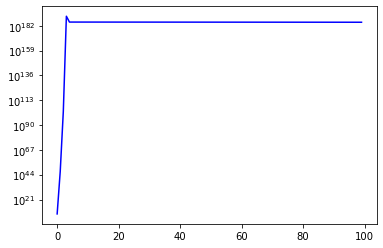

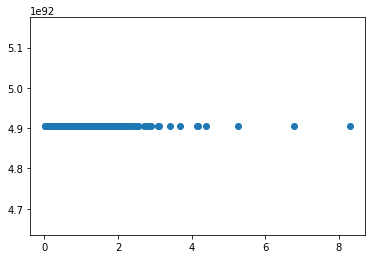

-6.344265011929003e+185

In [48]:
#x_data   = np.array([PrimaryUPod[:,9], PrimaryUPod[:,10] , PrimaryUPod[:,9] * PrimaryUPod[:,10], PrimaryUPod[:,1], PrimaryUPod[:,8], PrimaryUPod[:,0]]).T
x_train  = x_data2[train,:]
xx_train = x_train#[:,:-1]
print(xx_train.shape)
#xx_train[:,-1] = xx_train[:,-1] - xx_train[:,-1].min()#/ np.linalg.norm(xx_train[:,-1],axis=0)
xx_train = torch.from_numpy(xx_train)# .float().to(device)
benz_train = get_column(PrimaryUPod, labels, 'Benz')[train]
benz_test = get_column(PrimaryUPod, labels, 'Benz')[test2]
linear_dim = [xx_train.shape[1], 16, 16, 1]
#benz_train = torch.from_numpy(benz_train[:4]).to(device).float()
yy_train = torch.from_numpy(benz_train)#.float()#.to(device)

model = NeuralNet(linear_dim).double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.)#, momentum=0.9)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model normally
losses_train = train_NN(model, xx_train, yy_train.resShape(-1,1), optimizer, criterion, n_epoch= 100)
min(losses_train) # result is trash because of time T_T

# show results more concretely
y_pred, y_true = model(xx_train) , yy_train
plt.figure()
plt.scatter(y_true.detach().numpy(), y_pred.detach().numpy())
plt.show()
mdl_score.score(y_pred.detach().numpy(), y_true.detach().numpy())

### Train a model for all Sums concurrently

In [14]:
model

NeuralNet(
  (linlayers): ModuleList(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
  (act): ReLU()
)

In [15]:
def train(data_loader, model, optimizer, epoch, criterion, device='cpu'):
    # set the model to training mode
    model.train()

    losses = averageMeter()
    for (step, value) in enumerate(data_loader):

        data = value[:,:-1]
        target = value[:,-1]

        optimizer.zero_grad()

        # forward the data to the model and get the output
        output = model(data)

        # compute loss with the output and the target
        loss = criterion(output, target.reshape(-1,1))

        # backward (PyTorch computes backpropagation for you)
        loss.backward()

        optimizer.step()

        # accumulate losses
        losses.update(loss.item(), data.size(0))

    print(f"[Epoch: {epoch}]\t lr: {optimizer.param_groups[0]['lr']:.4g}\t \
      loss_train: {losses.avg:.4f}")
    return losses.avg

def train_NN(model, train_loader, batch_size=64, lr=0.1, n_epoch=30, eval_epoch=5):
    # setup optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # training and evaluation
    losses_train = []
    for ep in range(n_epoch):

        # train an epoch and get the loss
        loss_train = train(train_loader, model, optimizer, ep, criterion, device)
        losses_train.append(loss_train)

    # plot the training/testing loss and accuracy
    plt.plot(np.arange(n_epoch), losses_train, color='b', label='train_loss')

In [16]:
data_l = torch.cat((xx_train, yy_train.reshape(-1,1)), dim=1)
training_loader = torch.utils.data.DataLoader(data_l, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(data_l, batch_size=4, shuffle=False)
model1 = NeuralNetwork()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


NameError: name 'NeuralNetwork' is not defined

In [ ]:
train_NN(model, training_loader, lr=0.001)

In [ ]:
y_pred, y_true = model(xx_train) , yy_train
plt.scatter(y_true.detach().numpy(), y_pred.detach().numpy())
plt.show()
u = (y_true - y_pred).square().sum()
v = ((y_true - y_true.mean()).square()).sum()
1 - u/v